# Supply-Demand factors that influence the US home prices

**Data Info**:

`UNEM_RATE`: Unemployment rate in US over last 20 years.

`MORTGAGE` : Mortgage rate/ interest rate.

`GDPC1` : GDP of the US economy.

`FORECLOSURES` : The rate of foreclosures on residential property.

`Permit_Number` : Number of building permits allotted.

`Construction` : The amount spent (in millions of USD) is a measure of the activity in the construction industry.

`Homes_Sold` : The number of existing/previously-owned homes sold.

`Housing_Starts` : This is a measure of the number of units of new housing projects started in a given period.

`CSUSHPISA` : The Case-Shiller National Home Price Index used as a proxy for `HPI` and our target variable.

In [1]:
# Importing required libraries
import numpy as np         # Linear algebra
import pandas as pd        # Data processing

# Data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Data Preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split,cross_val_score as CVS, GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# model evaluation metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# optional setting for notebook theme and warnings
import warnings
warnings.filterwarnings('ignore')
sns.set(context = 'notebook',style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

In [2]:
# Loading data
df1 = pd.read_csv('demand_data.csv')
df2 = pd.read_csv(('supply_data.csv'))
mortgage = pd.read_csv('MORTGAGE30US.csv')
unemrate = pd.read_csv('UNRATE.csv')
y = pd.read_csv('CSUSHPISA.csv')

In [3]:
mortgage.head()

,DATE,MORTGAGE30US
0,1971-04-01,7.3100
1,1971-05-01,7.4250
2,1971-06-01,7.5300
3,1971-07-01,7.6040
4,1971-08-01,7.6975


In [4]:
unemrate.head()

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [5]:
y.head()

,DATE,CSUSHPISA
0,1987-01-01,63.965
1,1987-02-01,64.424
2,1987-03-01,64.735
3,1987-04-01,65.131
4,1987-05-01,65.563


In [6]:
df1.head()

,DATE,UNEM_RATE,MORTGAGE,GDPC1,FORECLOSURES,HPI
0,2000-01-01,4.03,8.26,12935.252,1.95,101.34
1,2000-04-01,3.93,8.32,13170.749,1.97,103.67
2,2000-07-01,4.00,8.02,13183.890,2.09,105.79
3,2000-10-01,3.90,7.62,13262.250,2.23,108.27
4,2001-01-01,4.23,7.01,13219.251,2.34,110.48


In [7]:
df2.head()

,Unnamed: 0,Period,Permit_Number,construction,Homes_Sold,Housing_Starts
0,1,01-01-2000,1727,353065,873,1636
1,2,01-02-2000,1692,351933,856,1737
2,3,01-03-2000,1651,353452,900,1604
3,4,01-04-2000,1597,356188,841,1626
4,5,01-05-2000,1543,349907,857,1575


In [8]:
# renaming DATE column for merging
df1.rename(columns={'DATE':'Date'},inplace=True)
y.rename(columns={'DATE':'Date'},inplace=True)
mortgage.rename(columns={'DATE':'Date'},inplace=True)
unemrate.rename(columns={'DATE':'Date'},inplace=True)

In [9]:
# converting datatypes
df1['Date'] = pd.to_datetime(df1['Date']).dt.strftime('%Y-%m-%d')
df2['Date'] = pd.to_datetime(df2['Period'],format = '%d-%m-%Y').dt.strftime('%Y-%m-%d')
y['Date'] = pd.to_datetime(y['Date']).dt.strftime('%Y-%m-%d')
mortgage['Date'] = pd.to_datetime(mortgage['Date']).dt.strftime('%Y-%m-%d')
unemrate['Date'] = pd.to_datetime(unemrate['Date']).dt.strftime('%Y-%m-%d')

In [10]:
# dropping irrelavant columns
df1.drop(['UNEM_RATE','MORTGAGE','HPI'],axis = 1, inplace = True)
df2.drop(['Unnamed: 0','Period'],axis = 1,inplace = True)

# y.drop('DATE',axis = 1, inplace = True)

In [11]:
# merging all data
df = pd.merge(df1,df2,on ='Date',how='right')
df = pd.merge(df,y, on = 'Date', how = 'left')
df = pd.merge(df,mortgage, on = 'Date',how = 'left')
df = pd.merge(df,unemrate, on = 'Date', how = 'left')

In [12]:
df.head()

,Date,GDPC1,FORECLOSURES,Permit_Number,construction,Homes_Sold,Housing_Starts,CSUSHPISA,MORTGAGE30US,UNRATE
0,2000-01-01,12935.252,1.95,1727,353065,873,1636,100.551,8.2100,4.0
1,2000-02-01,NaN,NaN,1692,351933,856,1737,101.339,8.3250,4.1
2,2000-03-01,NaN,NaN,1651,353452,900,1604,102.126,8.2400,4.0
3,2000-04-01,13170.749,1.97,1597,356188,841,1626,102.922,8.1525,3.8
4,2000-05-01,NaN,NaN,1543,349907,857,1575,103.677,8.5150,4.0


In [13]:
# renaming columns
df.rename(columns = {'UNRATE': 'Unem_Rate','MORTGAGE30US':'Mortgage', 'FORECLOSURES':'Foreclosures'},inplace = True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            250 non-null    object 
 1   GDPC1           84 non-null     float64
 2   Foreclosures    84 non-null     float64
 3   Permit_Number   250 non-null    int64  
 4   construction    250 non-null    int64  
 5   Homes_Sold      250 non-null    int64  
 6   Housing_Starts  250 non-null    int64  
 7   CSUSHPISA       250 non-null    float64
 8   Mortgage        250 non-null    float64
 9   Unem_Rate       250 non-null    float64
dtypes: float64(5), int64(4), object(1)
memory usage: 21.5+ KB


In [15]:
# Statistical info
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GDPC1,84.0,15968.048810,1762.701831,12935.252,14821.741750,15768.52850,17394.926250,19202.310
Foreclosures,84.0,4.745119,3.290622,1.410,2.097500,3.16000,7.517500,11.540
Permit_Number,250.0,1317.200000,470.104252,513.000,998.500000,1302.00000,1658.250000,2263.000
construction,250.0,428859.360000,122721.914363,236512.000,340081.750000,415920.00000,537308.750000,678562.000
Homes_Sold,250.0,697.272000,300.035978,270.000,436.500000,624.50000,940.500000,1389.000
Housing_Starts,250.0,1269.060000,460.534507,478.000,926.250000,1218.00000,1625.750000,2273.000
CSUSHPISA,250.0,161.075300,30.073262,100.551,140.222000,161.60750,182.819750,229.888
Mortgage,250.0,5.111916,1.314972,2.834,3.964875,4.86175,6.146875,8.515
Unem_Rate,250.0,5.981200,1.984682,3.500,4.525000,5.40000,7.200000,14.700


In [16]:
# checking for null values
print('No of null values:\n\n',df.isnull().sum().sort_values(ascending = False))

print('\n\nPercentage of null values:\n\n',df.isnull().mean().sort_values(ascending = False))

No of null values:

 GDPC1             166
Foreclosures      166
Date                0
Permit_Number       0
construction        0
Homes_Sold          0
Housing_Starts      0
CSUSHPISA           0
Mortgage            0
Unem_Rate           0
dtype: int64


Percentage of null values:

 GDPC1             0.664
Foreclosures      0.664
Date              0.000
Permit_Number     0.000
construction      0.000
Homes_Sold        0.000
Housing_Starts    0.000
CSUSHPISA         0.000
Mortgage          0.000
Unem_Rate         0.000
dtype: float64


In [17]:
# Unique counts
df.nunique()

Date              250
GDPC1              84
Foreclosures       79
Permit_Number     234
construction      250
Homes_Sold        213
Housing_Starts    233
CSUSHPISA         250
Mortgage          242
Unem_Rate          63
dtype: int64

In [18]:
df.sort_values(by='Date',inplace=True)
df.set_index('Date',inplace = True)

As there are 66% null values in the dataset we will use IterativeImputer to fill them.

__IterativeImputer__ : _In this each feature is imputed sequentially, one after the other, allowing prior imputed values to be used as part of a model in predicting subsequent features. This process is repeated multiple times, and the repetition allows the refined estimated values for other features to be used as input in subsequent iterations of predicting missing values. This is generally referred to as iterative imputation_.

In [19]:
# Using Iterative imputer to fill null values
imputer = IterativeImputer(max_iter=10,random_state=42)
imputer

IterativeImputer(random_state=42)

In [20]:
# creating new dataframe with imputed values
new_df = pd.DataFrame(imputer.fit_transform(df),columns=df.columns)

In [21]:
new_df.head()

,GDPC1,Foreclosures,Permit_Number,construction,Homes_Sold,Housing_Starts,CSUSHPISA,Mortgage,Unem_Rate
0,12935.252000,1.950000,1727.0,353065.0,873.0,1636.0,100.551,8.2100,4.0
1,12478.487402,2.746660,1692.0,351933.0,856.0,1737.0,101.339,8.3250,4.1
2,12404.535833,2.891214,1651.0,353452.0,900.0,1604.0,102.126,8.2400,4.0
3,13170.749000,1.970000,1597.0,356188.0,841.0,1626.0,102.922,8.1525,3.8
4,12353.194408,3.034380,1543.0,349907.0,857.0,1575.0,103.677,8.5150,4.0


In [22]:
# Checking for null values
new_df.isna().sum().sum()

0

In [23]:
# checking for duplicated entries
new_df.duplicated().sum()

0

In [24]:
# changing datatypes of Date column
new_df['Date'] = df.index
new_df['Date'] = pd.to_datetime(new_df['Date']).dt.strftime('%Y-%m-%d')

In [25]:
# new_df.index = pd.to_datetime(new_df.index)

In [26]:
new_df.describe().T

,count,mean,std,min,25%,50%,75%,max
GDPC1,250.0,15971.590470,1730.092367,12353.194408,14816.771263,15831.353667,17469.282214,19202.310
Foreclosures,250.0,4.753212,3.113147,-1.256793,2.452500,3.680000,7.025316,11.540
Permit_Number,250.0,1317.200000,470.104252,513.000000,998.500000,1302.000000,1658.250000,2263.000
construction,250.0,428859.360000,122721.914363,236512.000000,340081.750000,415920.000000,537308.750000,678562.000
Homes_Sold,250.0,697.272000,300.035978,270.000000,436.500000,624.500000,940.500000,1389.000
Housing_Starts,250.0,1269.060000,460.534507,478.000000,926.250000,1218.000000,1625.750000,2273.000
CSUSHPISA,250.0,161.075300,30.073262,100.551000,140.222000,161.607500,182.819750,229.888
Mortgage,250.0,5.111916,1.314972,2.834000,3.964875,4.861750,6.146875,8.515
Unem_Rate,250.0,5.981200,1.984682,3.500000,4.525000,5.400000,7.200000,14.700


_If we compare this to previous data's statistical analysis there's not much difference after dealing with null values._

In [27]:
years = pd.to_datetime(new_df['Date']).dt.year.astype(int)

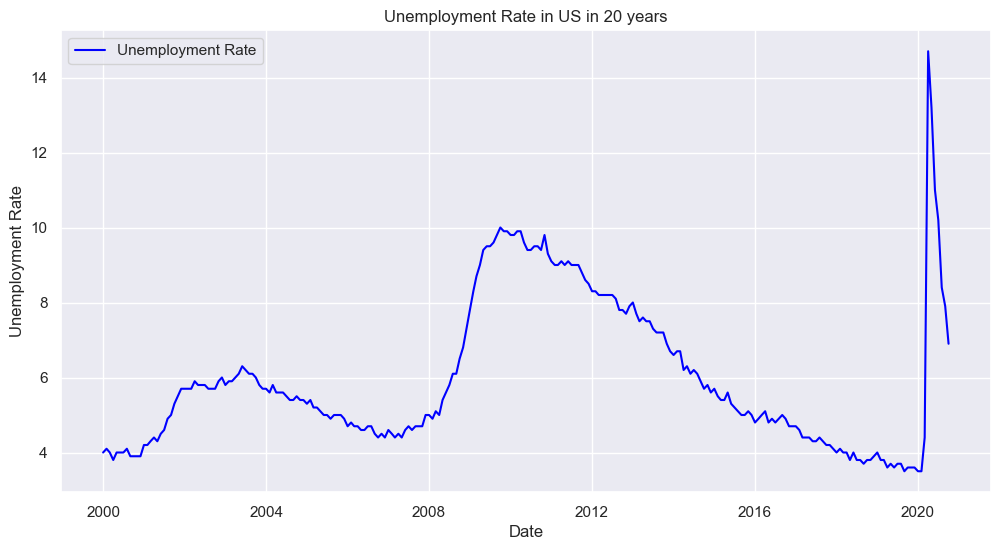

In [28]:
new_df['Date'] = pd.to_datetime(new_df['Date'])

plt.figure(figsize=(12, 6))
plt.plot(new_df['Date'], new_df['Unem_Rate'], label='Unemployment Rate', color='blue')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate in US in 20 years')
plt.legend()
plt.grid(True)
plt.show()

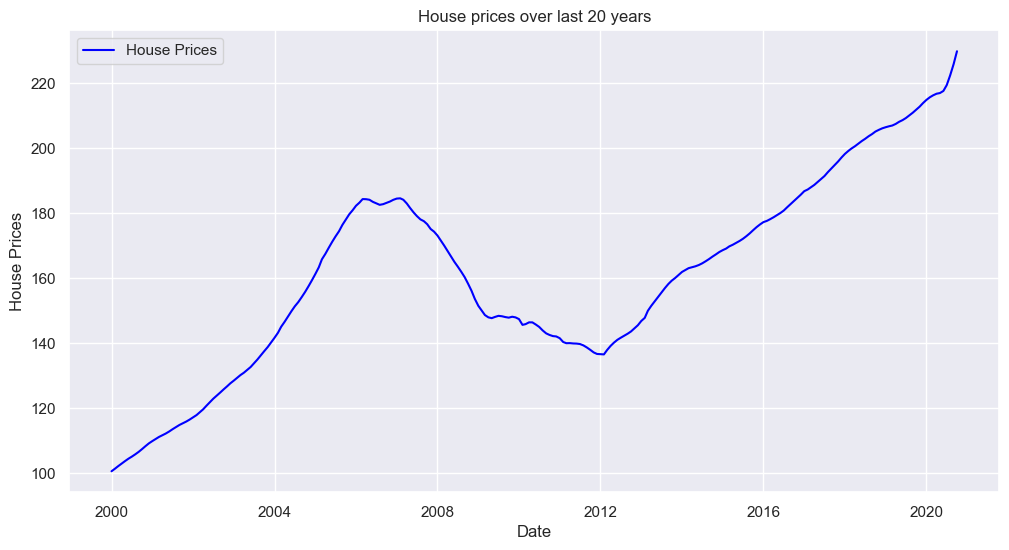

In [29]:
new_df['Date'] = pd.to_datetime(new_df['Date'])

plt.figure(figsize=(12, 6))
plt.plot(new_df['Date'], new_df['CSUSHPISA'], label='House Prices', color='blue')
plt.xlabel('Date')
plt.ylabel('House Prices')
plt.title('House prices over last 20 years')
plt.legend()
plt.grid(True)
plt.show()

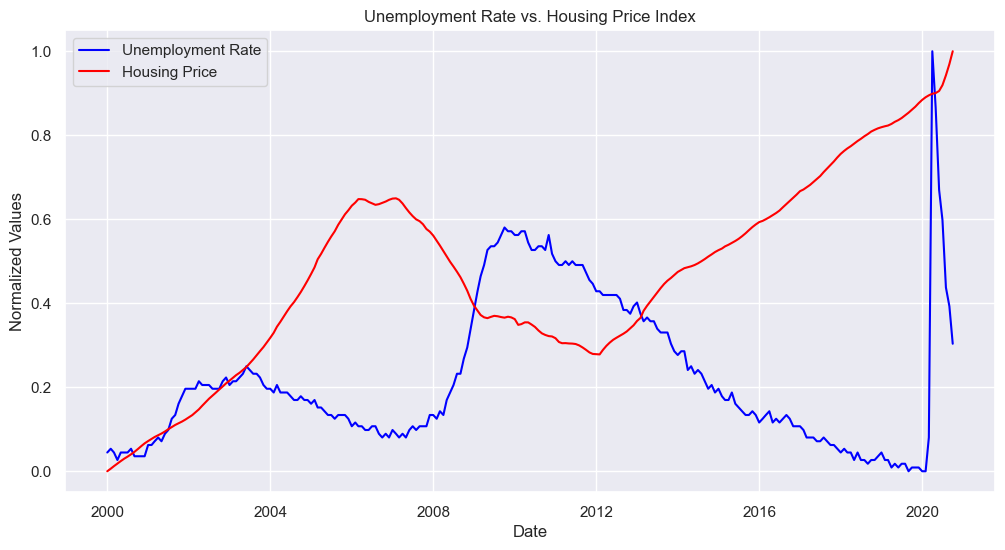

In [30]:
new_df['Date'] = pd.to_datetime(new_df['Date'])

# Normalizing the 'Unem_Rate' and 'house price' columns
scaler = MinMaxScaler()
new_df['Unem_Rate_normalized'] = scaler.fit_transform(new_df[['Unem_Rate']])
new_df['HPI_normalized'] = scaler.fit_transform(new_df[['CSUSHPISA']])

# plotting graph
plt.figure(figsize=(12, 6))

plt.plot(new_df['Date'], new_df['Unem_Rate_normalized'], label='Unemployment Rate', color='blue')
plt.plot(new_df['Date'], new_df['HPI_normalized'], label='Housing Price', color='red')

plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Unemployment Rate vs. Housing Price Index')
plt.legend()
plt.grid(True)

plt.show()
new_df.drop(['Unem_Rate_normalized','HPI_normalized'],axis = 1, inplace = True)

- __Unemployment rate graph__ :The unemployment rate was relatively low and stable from 2000 to 2007, ranging from 3.6% to 6.3%, then it spiked sharply in 2008 to 2009 to a peak of 10% and then again gradually declined from 2010 to 2019, reaching a low of 3.5%.

- __House prices graph__ :Here we can see that there is steady rise from 2000 -2006, a sharp decline from 2006 - 2012, and a recovery from 2012 - 2020.

__Conclusion__: unemployment rate is a reason for change in house prices over last 20 years. They both are inversly proportional to each other.

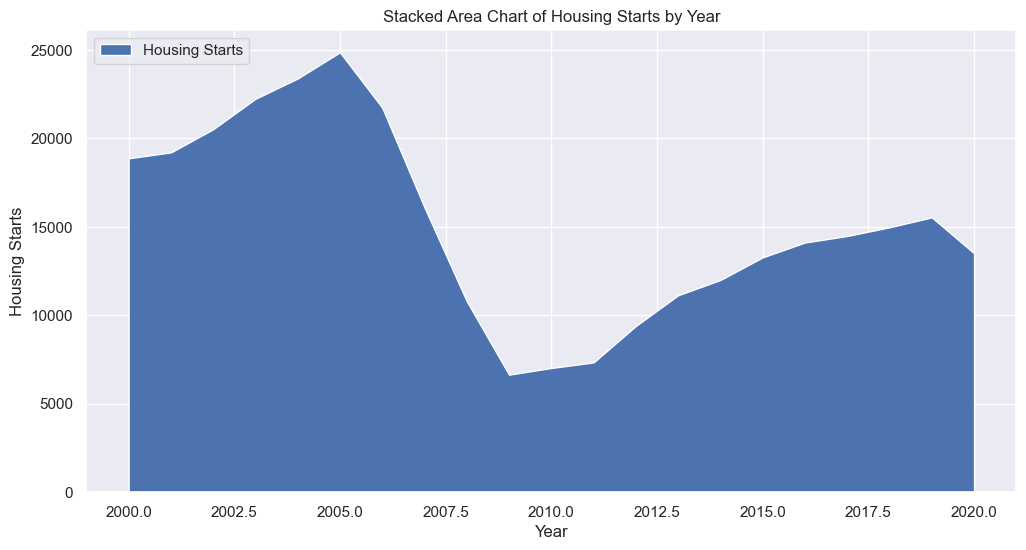

In [31]:
new_df['Year'] = new_df['Date'].dt.year
stacked_data = new_df.groupby(['Year'])['Housing_Starts'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.stackplot(stacked_data['Year'], stacked_data['Housing_Starts'], labels=['Housing Starts'])
plt.xlabel('Year')
plt.ylabel('Housing Starts')
plt.title('Stacked Area Chart of Housing Starts by Year')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [32]:
def plot_line_with_years(data, y, y_label):
    plt.figure(figsize=(13, 4))
    sns.lineplot(data=data, x=years, y=y, errorbar=None)
    plt.xlabel('Year')
    plt.xticks(years)
    plt.ylabel(y_label)
    plt.show()

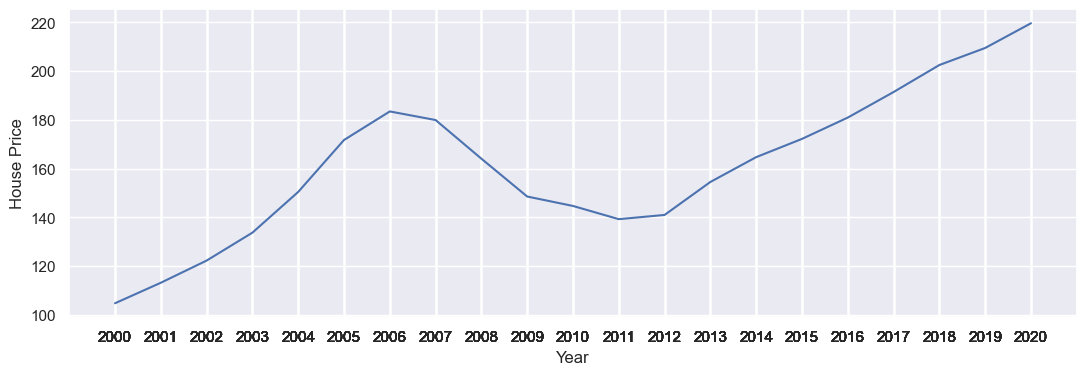

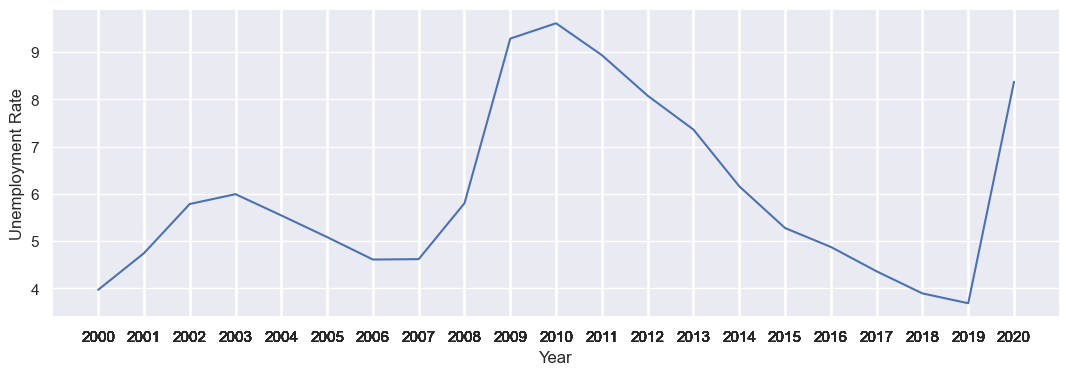

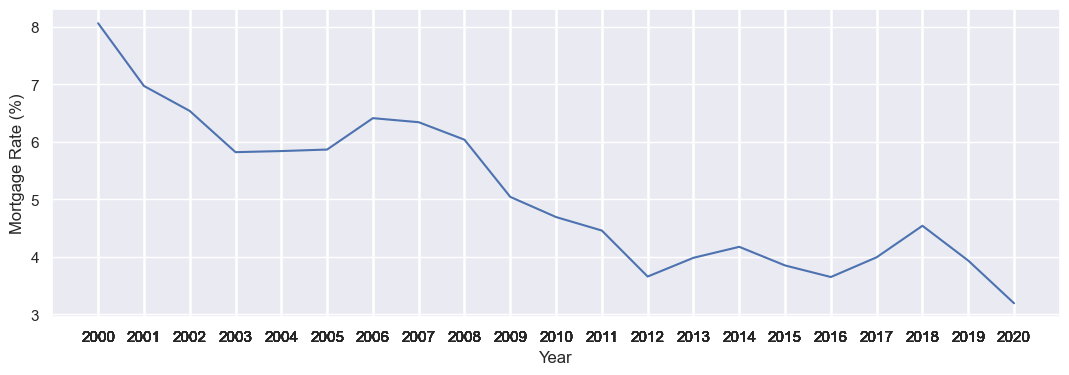

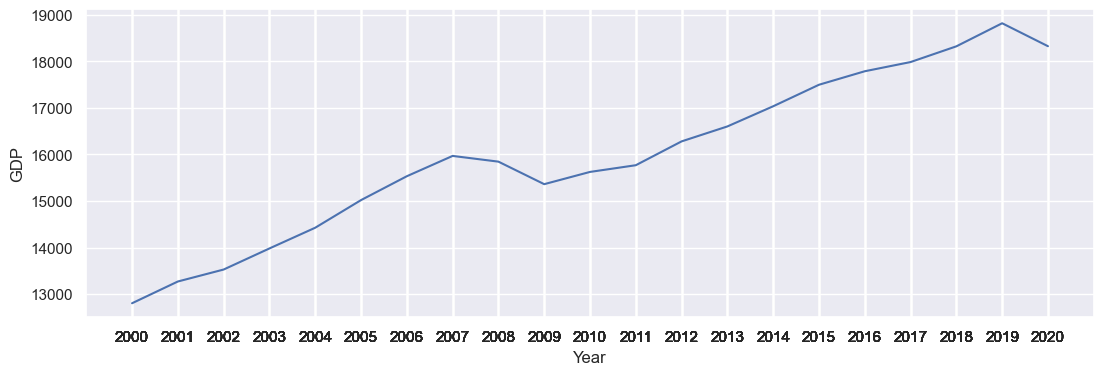

In [33]:
plot_line_with_years(new_df,y = 'CSUSHPISA', y_label='House Price')
plot_line_with_years(new_df,y = 'Unem_Rate', y_label='Unemployment Rate')
plot_line_with_years(new_df,y = 'Mortgage', y_label='Mortgage Rate (%)')
plot_line_with_years(new_df,y = 'GDPC1', y_label='GDP')

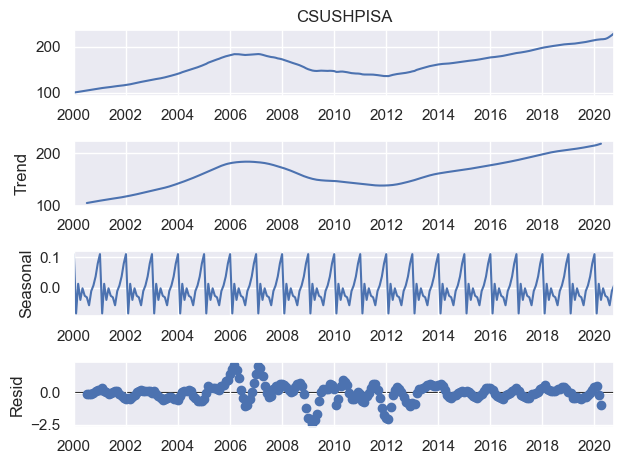

In [34]:
temp = new_df.set_index('Date')
temp.index = pd.to_datetime(temp.index)

# plot
decompose = seasonal_decompose(temp['CSUSHPISA'], model='additive', period=12)
decompose.plot()
plt.show()

Here we can see that there is ___steady rise___ from 2000 -2006, a ___sharp decline___ from 2006 - 2012, and a ___recovery___ from 2012 - 2020.

In Seasonal component we can see that there is same pattern every year.

<Figure size 1400x1000 with 0 Axes>

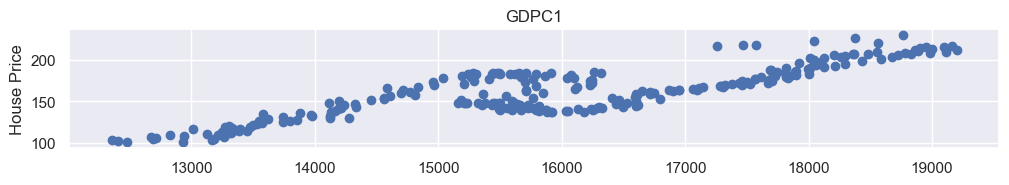

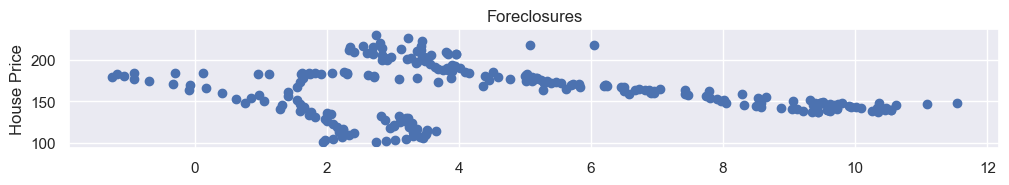

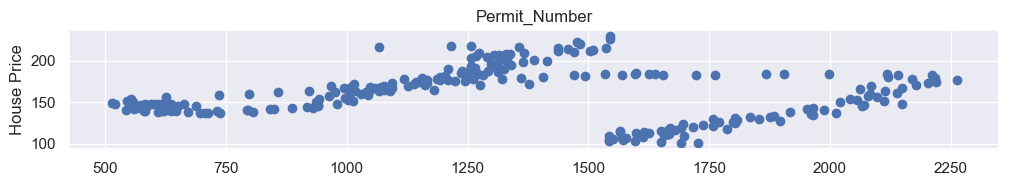

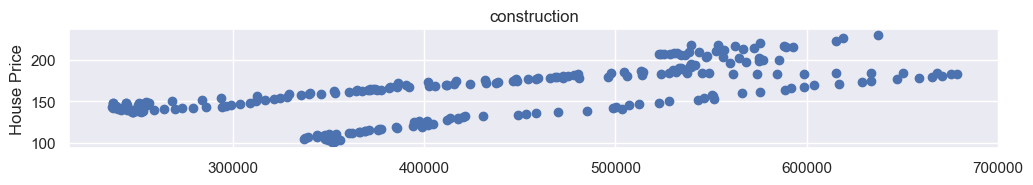

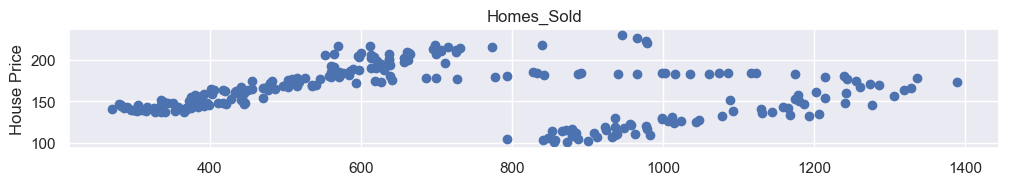

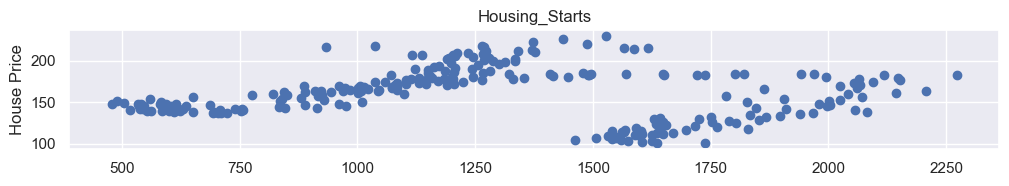

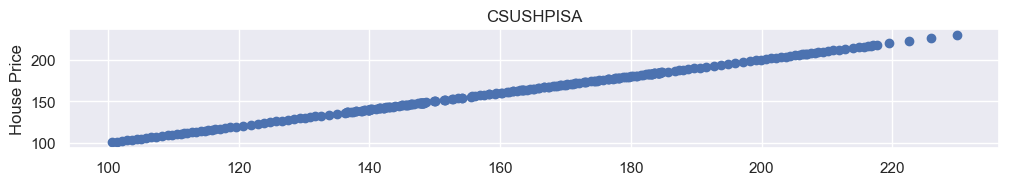

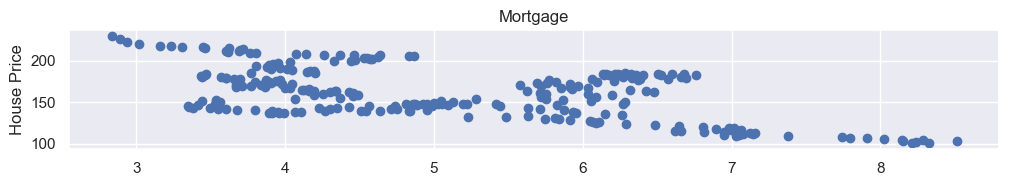

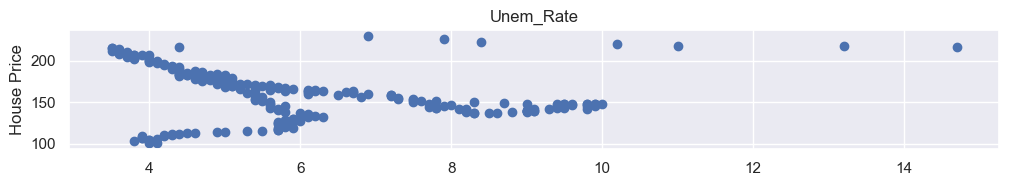

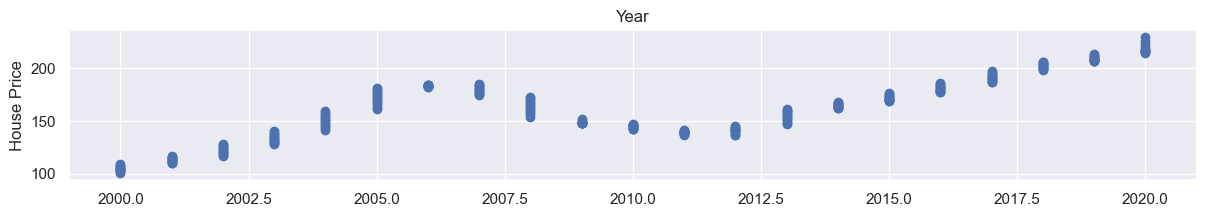

In [35]:
plt.figure(figsize=(14, 10))
cols = new_df.select_dtypes(include=[int, float]).columns.tolist()
num_plots = len(cols)
rows = 11
cols_per_row = num_plots // rows + 1

for i, col in enumerate(cols):
    plt.figure(figsize=(12, 20))
    plt.subplot(rows, cols_per_row, i + 1)
    plt.scatter(new_df[col], new_df['CSUSHPISA'])
    plt.ylabel('House Price')
    plt.title(col)

plt.tight_layout(pad=0.4, h_pad=0.4, w_pad=0.4)
plt.show()

There seems to be slightly positive correlation between `GDP` and `House Price`. And for others there's not a clear correlation.

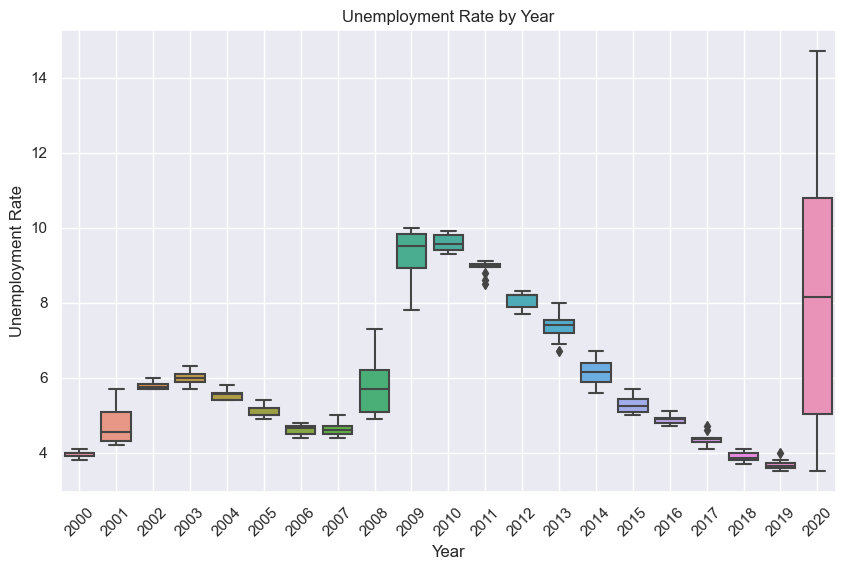

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Year', y='Unem_Rate', data=new_df)
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate by Year')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Unemployment rate in US has varied over time with some years having higher or lower values than others. The highest unemployment rate was in 2020 with most variance in that year. 

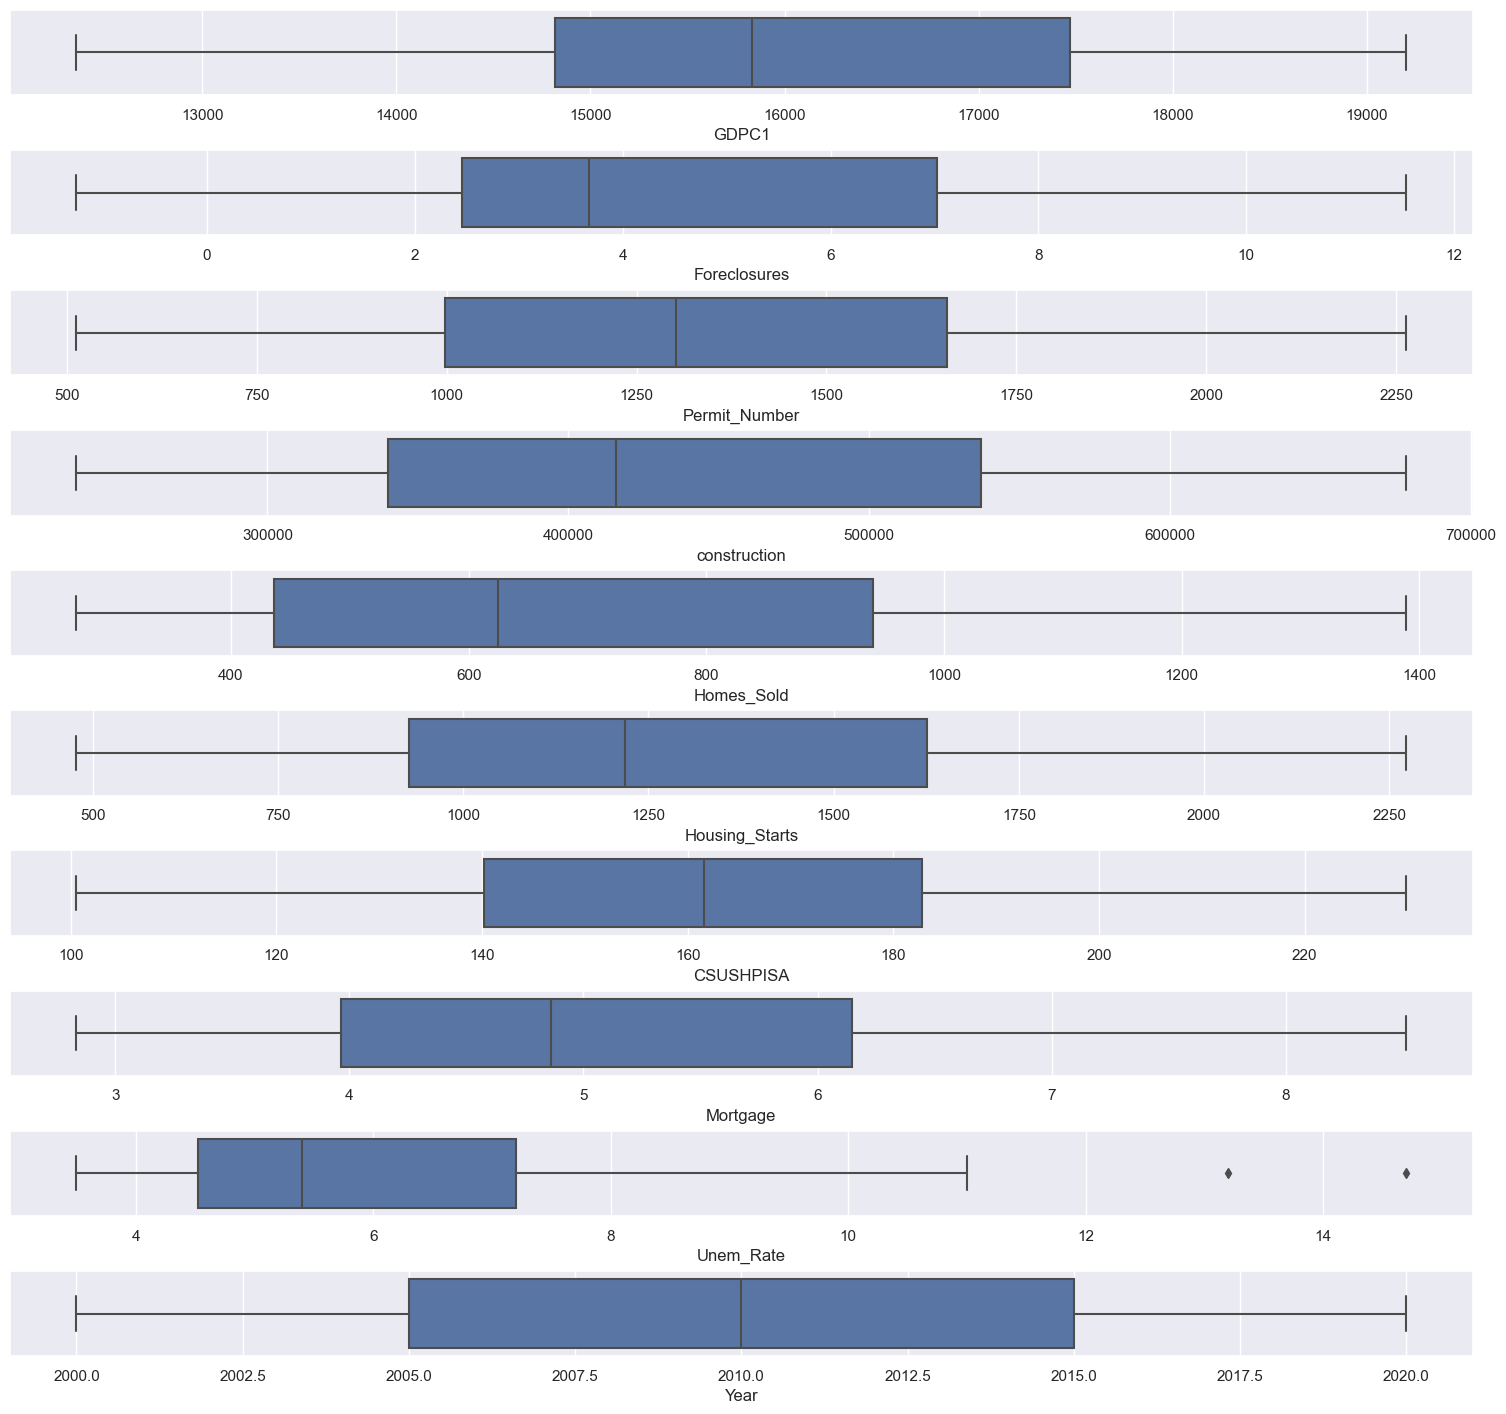

In [37]:
plt.figure(figsize=(15, 15))
cols = new_df.select_dtypes(include=[int, float]).columns.tolist()
num_plots = len(cols)
rows = 11
cols_per_row = num_plots // rows + 1

for i, col in enumerate(cols):
    plt.subplot(rows, cols_per_row, i + 1)
    sns.boxplot(x=new_df[col])

plt.tight_layout(pad=0.4, h_pad=0.4, w_pad=0.4)
plt.show()

In [38]:
# handling outliers
new_df = new_df[new_df.Unem_Rate <= 12]
new_df.reset_index(inplace = True,drop = True)

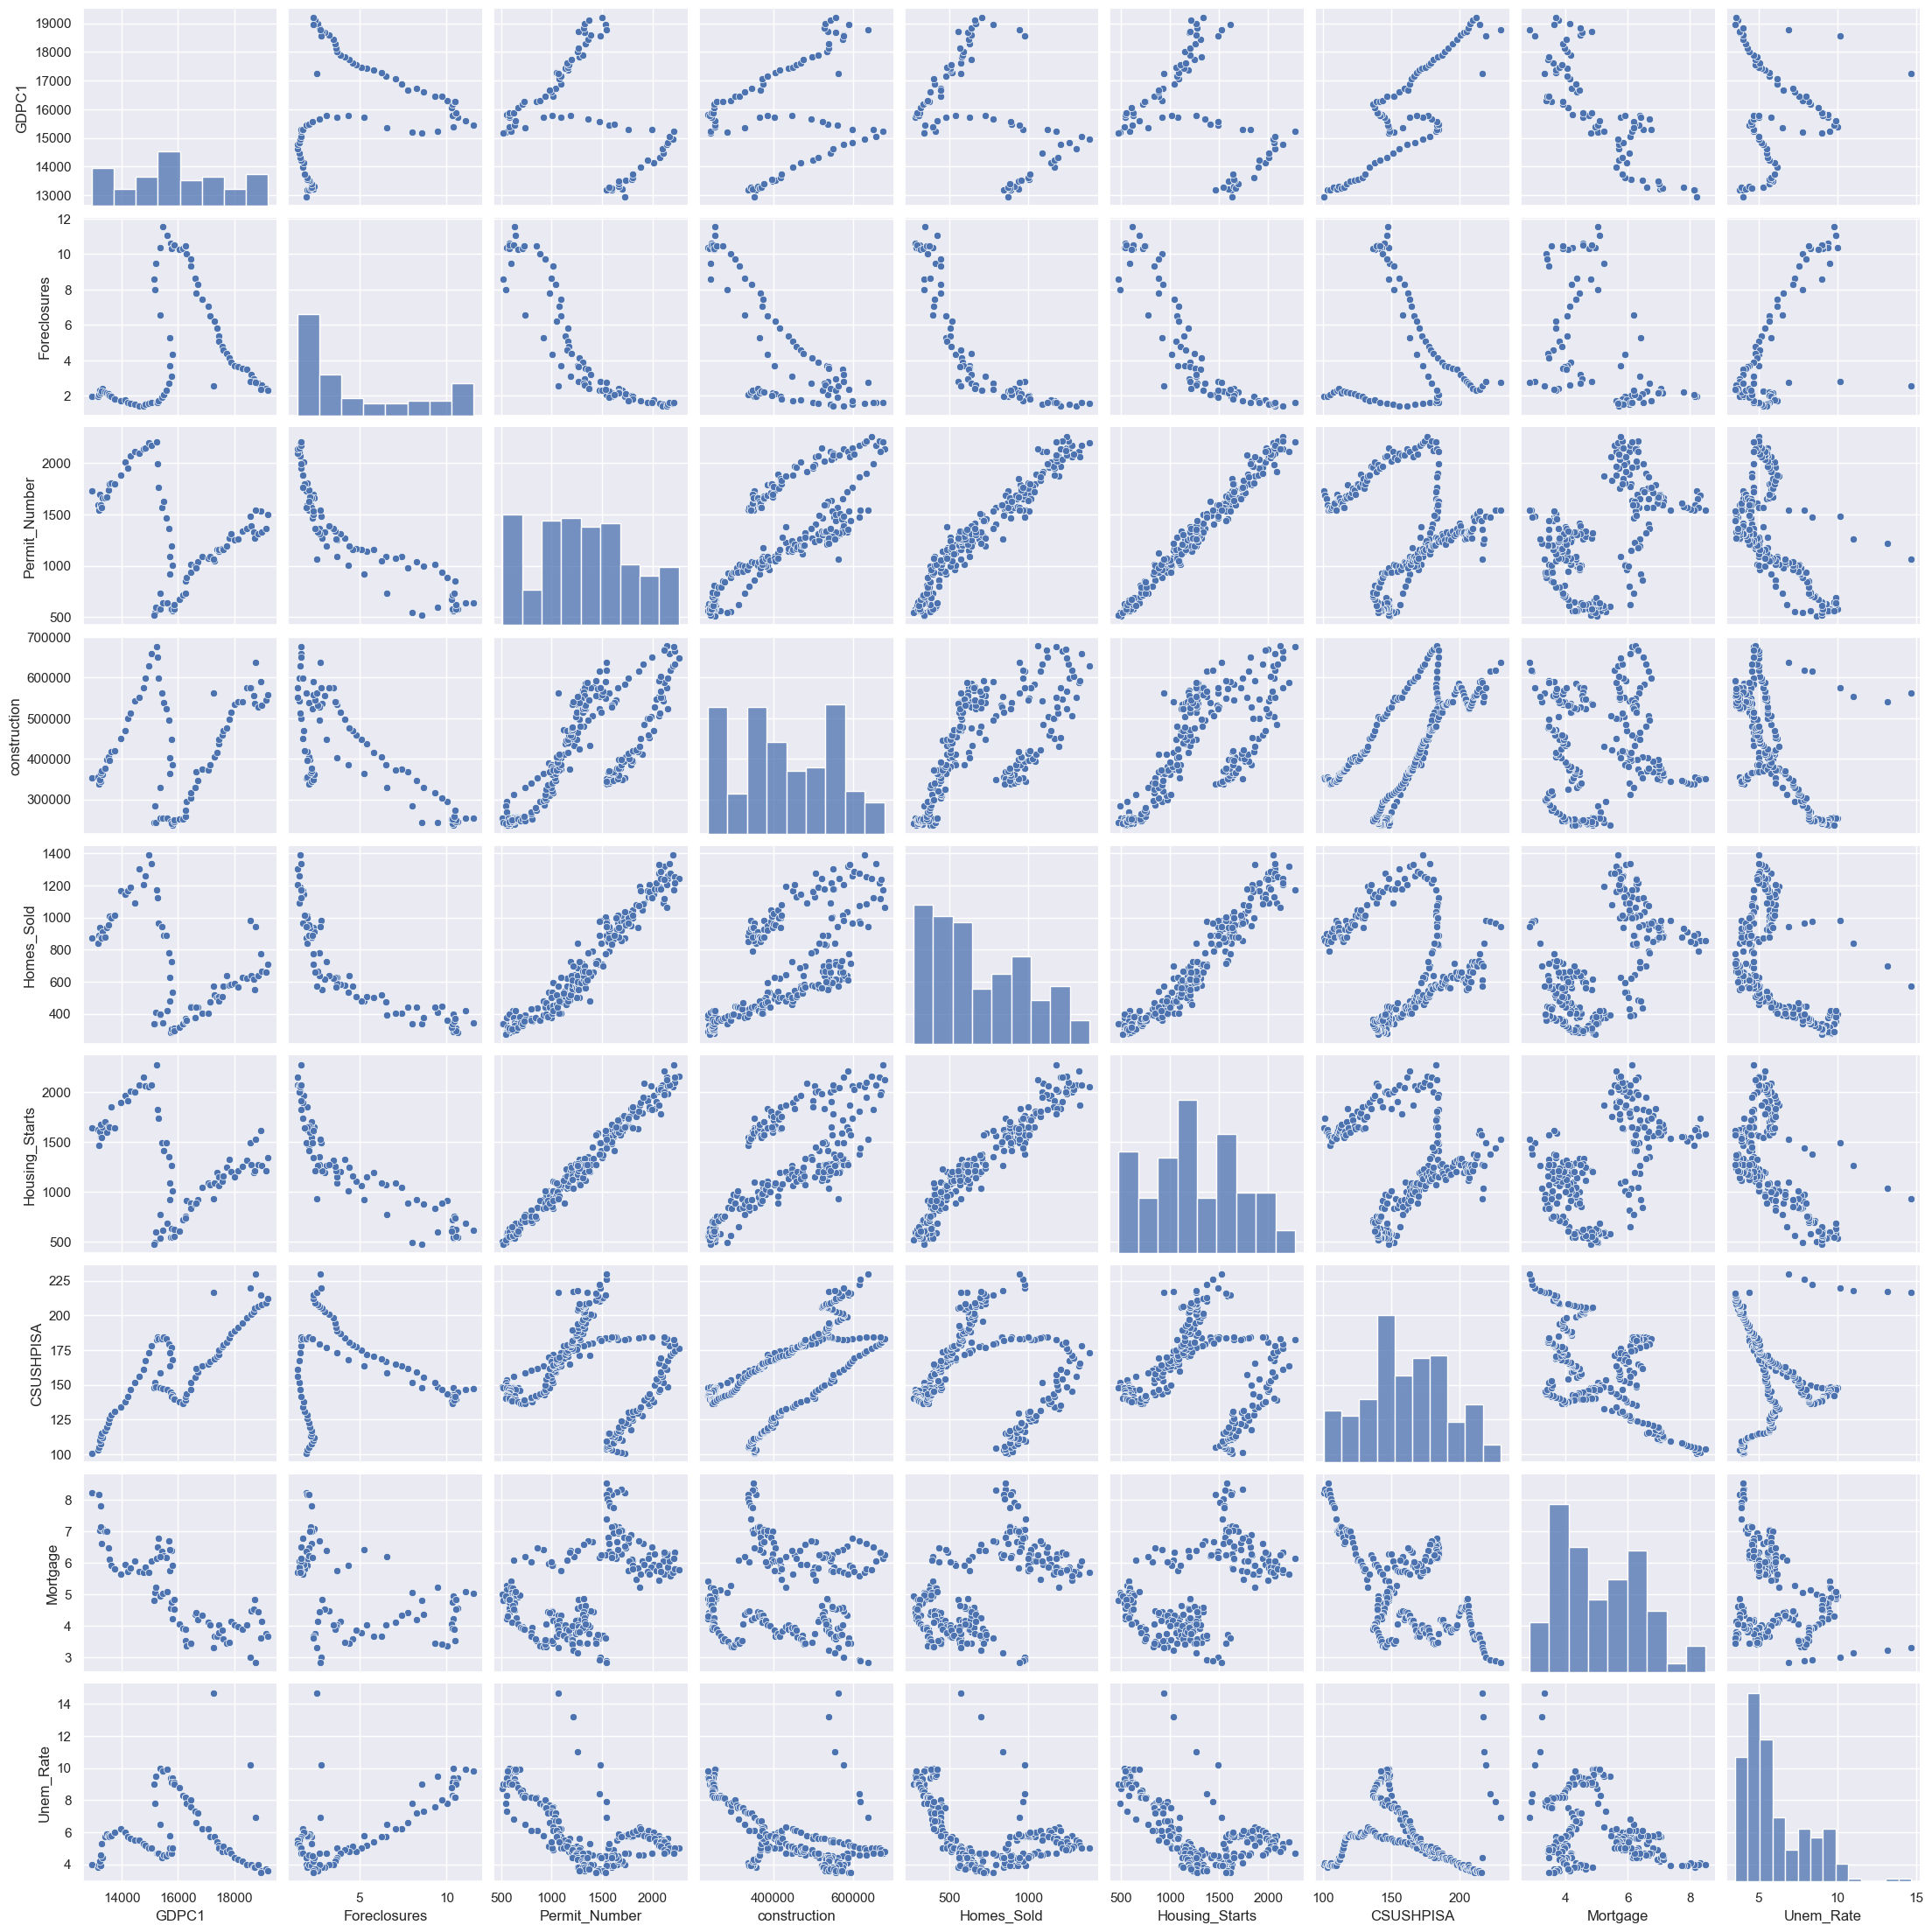

In [39]:
sns.pairplot(df)

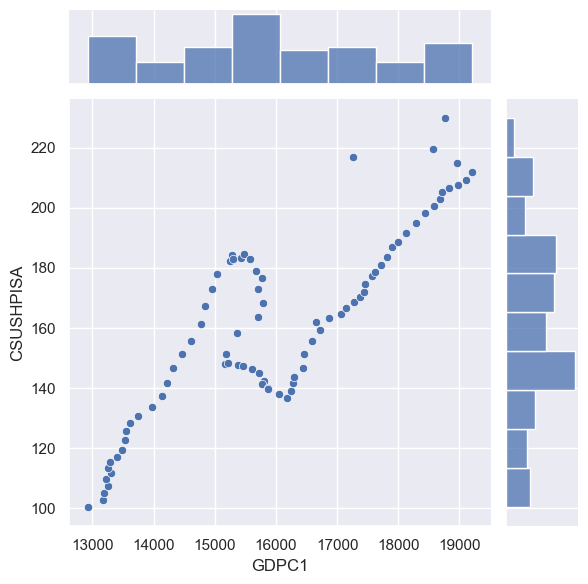

In [40]:
sns.jointplot(data = df, x = 'GDPC1', y = 'CSUSHPISA',palette='rainbow')

<Axes: >

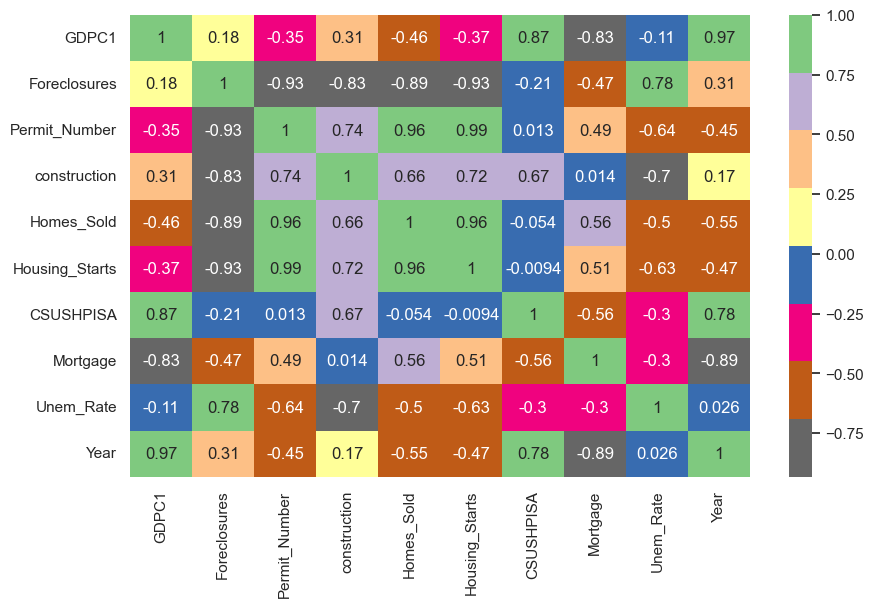

In [41]:
plt.figure(figsize= (10,6))
sns.heatmap(new_df.corr(),annot = True, cmap = 'Accent_r')

### Splitting data in input and target features

In [42]:
x = new_df.drop(['CSUSHPISA','Date','Year'],axis = 1)
y = new_df['CSUSHPISA']
# x = new_df[['Unem_Rate','Mortgage','GDPC1','Foreclosures','construction']]

### Standardization

In [43]:
scaler = StandardScaler()
scaler

StandardScaler()

In [44]:
x_scaled = pd.DataFrame(scaler.fit_transform(x), columns = x.columns)
x_scaled.head()

,GDPC1,Foreclosures,Permit_Number,construction,Homes_Sold,Housing_Starts,Mortgage,Unem_Rate
0,-1.749633,-0.901028,0.867535,-0.610836,0.583027,0.791474,2.358828,-1.034435
1,-2.013812,-0.645294,0.793183,-0.620079,0.526460,1.010690,2.446809,-0.980472
2,-2.056584,-0.598892,0.706085,-0.607676,0.672868,0.722019,2.381780,-1.034435
3,-1.613428,-0.894608,0.591371,-0.585336,0.476549,0.769769,2.314838,-1.142360
4,-2.086278,-0.552934,0.476657,-0.636622,0.529788,0.659076,2.592169,-1.034435


### splitting into train and test set

As the dataset is small we will use KFold to split the data to avoid overfitting or underfitting.

In [45]:
from sklearn.model_selection import KFold

k = 5  

# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(x_scaled):
    x_train, x_test = pd.DataFrame((np.array(x_scaled)[train_index]),columns=x_scaled.columns), pd.DataFrame((np.array(x_scaled)[test_index]),columns=x_scaled.columns)
    y_train, y_test = pd.DataFrame((np.array(y)[train_index]),columns = ['CSUSHPISA']), pd.DataFrame((np.array(y)[test_index]),columns = ['CSUSHPISA'])

In [46]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(199, 8) (49, 8) (199, 1) (49, 1)


# Model Building

- __Linear Regression__

In [47]:
model = LinearRegression()

# parameters
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

# GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# fitting with data
grid_search.fit(x_scaled, y)

# Print the best hyperparameters and their corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Negative Mean Squared Error:", -grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .....copy_X=True, fit_intercept=True, positive=True; total time=   0.0s
[CV] END .....copy_X=True, fit_intercept=True, positive=True; total time=   0.0s
[CV] END .....copy_X=True, fit_intercept=True, positive=True; total time=   0.0s
[CV] END .....copy_X=True, fit_intercept=True, positive=True; total time=   0.0s
[CV] END .....copy_X=True, fit_intercept=True, positive=True; total time=   0.0s
[CV] END ....copy_X=True, fit_intercept=True, positive=False; total time=   0.0s
[CV] END ....copy_X=True, fit_intercept=True, positive=False; total time=   0.0s
[CV] END ....copy_X=True, fit_intercept=True, positive=False; total time=   0.0s
[CV] END ....copy_X=True, fit_intercept=True, positive=False; total time=   0.0s
[CV] END ....copy_X=True, fit_intercept=True, positive=False; total time=   0.0s
[CV] END ....copy_X=True, fit_intercept=False, positive=True; total time=   0.0s
[CV] END ....copy_X=True, fit_intercept=False, po

In [48]:
lr = best_model
lr.fit(x_train,y_train)

LinearRegression()

In [49]:
lr_pred = lr.predict(x_test)
lr_MSE = round(mean_squared_error(y_test,lr_pred),2)
lr_MAE = round(mean_absolute_error(y_test,lr_pred),2)
lr_r2_score = round(r2_score(y_test,lr_pred),4)

In [50]:
print('MSE: ',lr_MSE)
print('MAE: ',lr_MAE)
print('r2_score: ',lr_r2_score)

MSE:  15.89
MAE:  2.8
r2_score:  0.9789


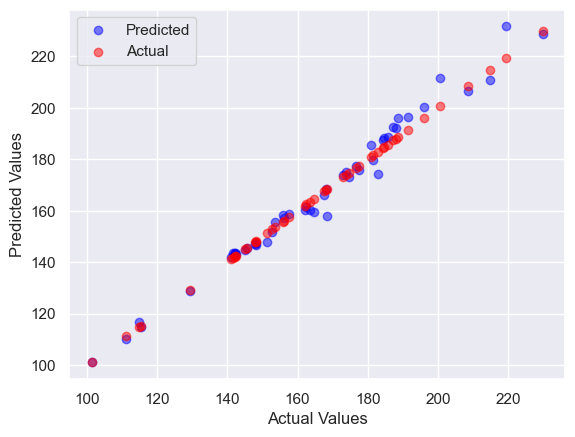

In [51]:
plt.scatter(y_test, lr_pred, c='blue', label='Predicted', alpha=0.5)
plt.scatter(y_test, y_test, c='red', label='Actual', alpha=0.5)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(loc='best')

- __RandomForestRegressor__

In [52]:
model = RandomForestRegressor()

# parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
}


# GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)


grid_search.fit(x_scaled, y)

# Print the best hyperparameters and their corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Negative Mean Squared Error:", -grid_search.best_score_)

# Get the best model
best_model1 = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.3s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.3s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.3s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.3s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.3s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.7s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.6s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.6s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.7s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.6s
[CV] END ...................max_depth=None, n_estimators=200; total time=   1.4s
[CV] END ...................max_depth=None, n_es

In [53]:
rf = best_model1
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=50)

In [54]:
rf_pred = rf.predict(x_test)
rf_MSE = round(mean_squared_error(y_test,rf_pred),2)
rf_MAE = round(mean_absolute_error(y_test,rf_pred),2)
rf_r2_score = round(r2_score(y_test,rf_pred),4)

In [55]:
print('MSE: ',rf_MSE)
print('MAE: ',rf_MAE)
print('r2_score: ',rf_r2_score)

MSE:  7.51
MAE:  1.94
r2_score:  0.99


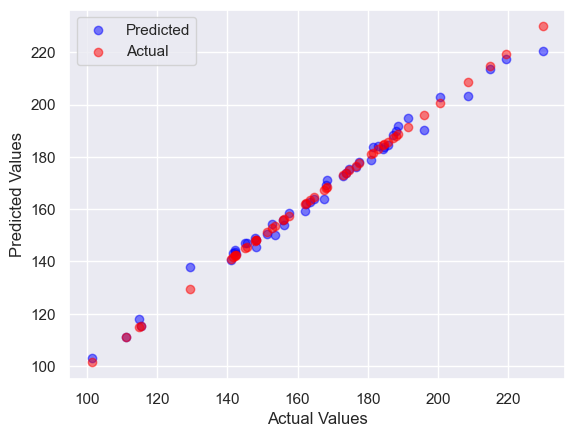

In [56]:
plt.scatter(y_test, rf_pred, c='blue', label='Predicted', alpha=0.5)
plt.scatter(y_test, y_test, c='red', label='Actual', alpha=0.5)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(loc='best')

- __DecisionTreeRegressor__

In [57]:
dt = DecisionTreeRegressor()

param_grid = {
    'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],  # Criterion for splitting
    'max_depth': [None, 5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to your data
grid_search.fit(x_scaled, y)

# Print the best hyperparameters and corresponding mean squared error (MSE)
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Mean Squared Error (MSE): {:.2f}".format(-grid_search.best_score_))

best_model2 = grid_search.best_estimator_

Best Hyperparameters:  {'criterion': 'poisson', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Mean Squared Error (MSE): 641.49


In [58]:
dt_model = best_model2
dt_model.fit(x_train,y_train)

DecisionTreeRegressor(criterion='poisson', max_depth=5, min_samples_leaf=4,
                      min_samples_split=10)

In [59]:
dt_pred = dt_model.predict(x_test)
dt_MSE = round(mean_squared_error(y_test,dt_pred),2)
dt_MAE = round(mean_absolute_error(y_test,dt_pred),2)
dt_r2_score = round(r2_score(y_test,dt_pred),4)

In [60]:
print('MSE: ',dt_MSE)
print('MAE: ',dt_MAE)
print('r2_score: ',dt_r2_score)

MSE:  46.21
MAE:  4.66
r2_score:  0.9386


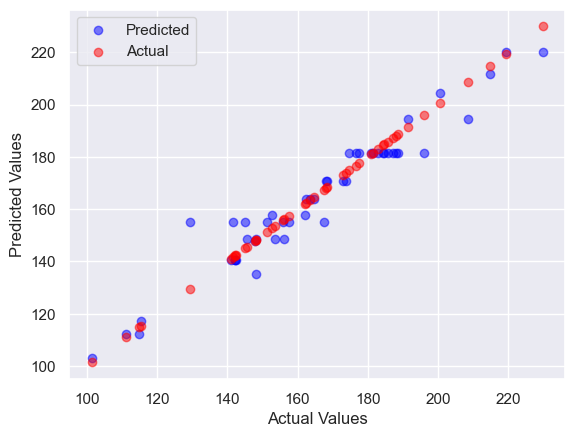

In [61]:
plt.scatter(y_test, dt_pred, c='blue', label='Predicted', alpha=0.5)
plt.scatter(y_test, y_test, c='red', label='Actual', alpha=0.5)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(loc='best')

- Models Performances

In [62]:
mse = [lr_MSE,rf_MSE,dt_MSE]
mae = [lr_MAE,rf_MAE,dt_MAE]
r2  = [lr_r2_score,rf_r2_score,dt_r2_score]

Models = pd.DataFrame({
    'models': ["LinearRegression","RandomForestRegressor","DecisionTreeRegressor"],
    'MAE': mae, 'MSE': mse, 'R^2':r2})
Models.sort_values(by='MAE', ascending=True)

,models,MAE,MSE,R^2
1,RandomForestRegressor,1.94,7.51,0.9900
0,LinearRegression,2.80,15.89,0.9789
2,DecisionTreeRegressor,4.66,46.21,0.9386


RandomForestRegressor model is performing good on this dataset as it is giving less __MAE__,__MSE__ with a higher __r2_score__ of 0.99.